Modelos

Librerias

In [57]:
import pandas as pd
from xgboost import XGBClassifier
import numpy as np
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV, TimeSeriesSplit,cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,log_loss, make_scorer, f1_score, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
import random
import seaborn as sns
import matplotlib.pyplot as plt

Lectura datos

In [58]:
df = pd.read_csv(".\\data\\data2\\datosmasc_2025-06-18.csv")

print(df['superficie'].unique())

df['cuotaA'] = df['cuotaA'].replace('-', np.nan)
df['cuotaB'] = df['cuotaB'].replace('-', np.nan)
df['cuotaA'] = df['cuotaA'].astype(float)
df['cuotaB'] = df['cuotaB'].astype(float)

c = ['setsA', 'setsB', 'porcentajePuntosGanadosAlRestoConPrimerSaqueB', 'porcentajePuntosGanadosAlRestoConSegundoSaqueB', 'porcentajePuntosGanadosB', 'porcentajeJuegosGanadosB', 'porcentajeJuegosGanadosPrimerSaqueB',
     'porcentajeJuegosGanadosSegundoSaqueB', 'porcentajePuntosGanadosAlRestoB', 'porcentajePuntosBreakConvertidosB', 'porcentajePuntosGanadosAlSaqueB', 'porcentajeJuegosGanadosAlSaqueB', 'porcentajeJuegosGanadosAlRestoB']
df = df.drop(columns = c)


# Crear un diccionario con un DataFrame por cada valor único
dfs_por_categoria = {valor: df[df['superficie'] == valor].copy() for valor in df['superficie'].unique()}

hierba = dfs_por_categoria['Grass']
dura = dfs_por_categoria['Hard']
tierra = dfs_por_categoria['Clay']

pd.set_option('display.max_columns', None)
display(hierba.head())

['Clay' 'Grass' 'Hard' 'Carpet']


,torneo,jugadorA,jugadorB,fecha,acesA,acesB,porcentajePrimerSaqueA,porcentajePrimerSaqueB,porcentajeBreakPointsSalvadosA,porcentajeBreakPointsSalvadosB,porcentajePuntosGanadosAlRestoConPrimerSaqueA,porcentajePuntosGanadosAlRestoConSegundoSaqueA,porcentajePuntosGanadosA,porcentajeJuegosGanadosA,cuotaA,cuotaB,dobleA,dobleB,porcentajeJuegosGanadosPrimerSaqueA,porcentajeJuegosGanadosSegundoSaqueA,porcentajePuntosGanadosAlRestoA,porcentajePuntosBreakConvertidosA,porcentajePuntosGanadosAlSaqueA,porcentajeJuegosGanadosAlSaqueA,porcentajeJuegosGanadosAlRestoA,superficie,hora,sets,ganador
23,nottingham,Choinski J.,Kachmazov A.,2025-06-15,9.0,10.0,58.0,57.0,83.0,71.0,19.0,57.0,52.0,53.0,2.15,1.6,5.0,12.0,81.0,56.0,35.0,29.0,70.0,94.0,11.0,Grass,14:55,3,0
25,nottingham,Gigante M.,Shimabukuro S.,2025-06-15,6.0,4.0,63.0,59.0,80.0,73.0,30.0,57.0,53.0,57.0,NaN,NaN,5.0,4.0,75.0,50.0,41.0,27.0,66.0,93.0,21.0,Grass,14:15,3,0
26,nottingham,Lestienne C.,Wong C.,2025-06-15,3.0,6.0,65.0,64.0,40.0,67.0,27.0,35.0,47.0,41.0,NaN,NaN,1.0,2.0,69.0,52.0,30.0,33.0,63.0,73.0,9.0,Grass,14:40,2,1
27,nottingham,Ajdukovic D.,Grenier H.,2025-06-15,8.0,14.0,64.0,74.0,57.0,83.0,23.0,60.0,49.0,43.0,1.60,2.1,2.0,7.0,79.0,45.0,33.0,17.0,67.0,80.0,7.0,Grass,14:40,3,1
28,nottingham,Gigante M.,Wong C.,2025-06-15,2.0,14.0,69.0,60.0,71.0,63.0,27.0,54.0,52.0,54.0,1.45,2.5,2.0,3.0,77.0,48.0,38.0,38.0,68.0,86.0,21.0,Grass,17:55,3,0


Separación

In [59]:
train = hierba[hierba['fecha'] < '2025-01-01']
test = hierba[hierba['fecha'] >= '2025-01-01']

print(len(train) / len(hierba))
print(len(test) / len(hierba))
display(test.head())

0.741826381059752
0.25817361894024804


,torneo,jugadorA,jugadorB,fecha,acesA,acesB,porcentajePrimerSaqueA,porcentajePrimerSaqueB,porcentajeBreakPointsSalvadosA,porcentajeBreakPointsSalvadosB,porcentajePuntosGanadosAlRestoConPrimerSaqueA,porcentajePuntosGanadosAlRestoConSegundoSaqueA,porcentajePuntosGanadosA,porcentajeJuegosGanadosA,cuotaA,cuotaB,dobleA,dobleB,porcentajeJuegosGanadosPrimerSaqueA,porcentajeJuegosGanadosSegundoSaqueA,porcentajePuntosGanadosAlRestoA,porcentajePuntosBreakConvertidosA,porcentajePuntosGanadosAlSaqueA,porcentajeJuegosGanadosAlSaqueA,porcentajeJuegosGanadosAlRestoA,superficie,hora,sets,ganador
23,nottingham,Choinski J.,Kachmazov A.,2025-06-15,9.0,10.0,58.0,57.0,83.0,71.0,19.0,57.0,52.0,53.0,2.15,1.6,5.0,12.0,81.0,56.0,35.0,29.0,70.0,94.0,11.0,Grass,14:55,3,0
25,nottingham,Gigante M.,Shimabukuro S.,2025-06-15,6.0,4.0,63.0,59.0,80.0,73.0,30.0,57.0,53.0,57.0,NaN,NaN,5.0,4.0,75.0,50.0,41.0,27.0,66.0,93.0,21.0,Grass,14:15,3,0
26,nottingham,Lestienne C.,Wong C.,2025-06-15,3.0,6.0,65.0,64.0,40.0,67.0,27.0,35.0,47.0,41.0,NaN,NaN,1.0,2.0,69.0,52.0,30.0,33.0,63.0,73.0,9.0,Grass,14:40,2,1
27,nottingham,Ajdukovic D.,Grenier H.,2025-06-15,8.0,14.0,64.0,74.0,57.0,83.0,23.0,60.0,49.0,43.0,1.60,2.1,2.0,7.0,79.0,45.0,33.0,17.0,67.0,80.0,7.0,Grass,14:40,3,1
28,nottingham,Gigante M.,Wong C.,2025-06-15,2.0,14.0,69.0,60.0,71.0,63.0,27.0,54.0,52.0,54.0,1.45,2.5,2.0,3.0,77.0,48.0,38.0,38.0,68.0,86.0,21.0,Grass,17:55,3,0


In [60]:
X_train = train.drop(columns=["torneo","jugadorA","jugadorB", "fecha", "hora", "superficie", "ganador"])
y_train = train["ganador"]
print("Train",y_train.value_counts(normalize=True))

X_test = test.drop(columns=["torneo","jugadorA","jugadorB", "fecha", "hora", "superficie", "ganador"])
y_test = test["ganador"]
print("Test",y_test.value_counts(normalize=True))

X_train.head()

Train ganador
0    0.507599
1    0.492401
Name: proportion, dtype: float64
Test ganador
1    0.558952
0    0.441048
Name: proportion, dtype: float64


,acesA,acesB,porcentajePrimerSaqueA,porcentajePrimerSaqueB,porcentajeBreakPointsSalvadosA,porcentajeBreakPointsSalvadosB,porcentajePuntosGanadosAlRestoConPrimerSaqueA,porcentajePuntosGanadosAlRestoConSegundoSaqueA,porcentajePuntosGanadosA,porcentajeJuegosGanadosA,cuotaA,cuotaB,dobleA,dobleB,porcentajeJuegosGanadosPrimerSaqueA,porcentajeJuegosGanadosSegundoSaqueA,porcentajePuntosGanadosAlRestoA,porcentajePuntosBreakConvertidosA,porcentajePuntosGanadosAlSaqueA,porcentajeJuegosGanadosAlSaqueA,porcentajeJuegosGanadosAlRestoA,sets
9831,11.0,4.0,58.0,63.0,86.0,57.0,35.0,41.0,52.0,55.0,1.67,2.10,4.0,3.0,77.0,47.0,37.0,43.0,64.0,87.0,21.0,3
9892,6.0,7.0,58.0,68.0,25.0,0.0,17.0,21.0,42.0,37.0,2.63,1.44,4.0,1.0,69.0,42.0,18.0,0.0,58.0,70.0,0.0,2
9897,4.0,13.0,69.0,66.0,0.0,50.0,23.0,66.0,50.0,50.0,2.38,1.53,1.0,3.0,67.0,64.0,37.0,50.0,66.0,79.0,21.0,3
9908,4.0,7.0,59.0,61.0,64.0,71.0,30.0,48.0,47.0,43.0,1.57,2.25,2.0,0.0,70.0,39.0,37.0,29.0,57.0,64.0,20.0,2
9909,6.0,6.0,69.0,58.0,0.0,33.0,27.0,56.0,58.0,63.0,1.83,1.83,0.0,3.0,82.0,80.0,39.0,67.0,82.0,100.0,22.0,2


Baseline

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.9475982532751092
F1-Score: 0.9524
AUC-ROC: 0.9803
Precisión: 0.9677
Sensibilidad: 0.9375
Log-loss: 0.22612895073368175


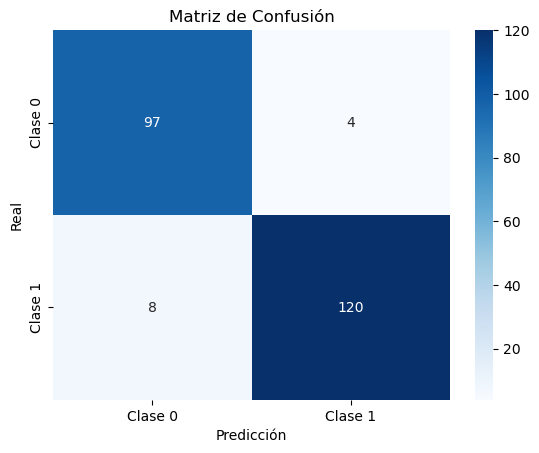

In [61]:
base = XGBClassifier(random_state=42)
base.fit(X_train,y_train)

print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = base.predict(X_test)
y_val_prob = base.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_val_pred))
f1_val = f1_score(y_test, y_val_pred)
roc_auc_val = roc_auc_score(y_test, y_val_prob)
precision_val = precision_score(y_test, y_val_pred)
recall_val = recall_score(y_test, y_val_pred)
log_loss_val = log_loss(y_test,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
# Asegurate que y_test sea un pd.Series y resetea su índice
y_test_reset = y_test.reset_index(drop=True)

# Si X_test no es DataFrame, convertirlo
X_test_df = X_test.copy() if isinstance(X_test, pd.DataFrame) else pd.DataFrame(X_test)

# Resetear el índice de X_test para que quede alineado con y_test
X_test_df = X_test_df.reset_index(drop=True)

# Ahora crear el DataFrame resultados con las columnas de X_test y las etiquetas reales y predichas
resultados = X_test_df.copy()
resultados['verdadero'] = y_test_reset
resultados['predicho'] = y_val_pred

# Filtrar los errores
errores = resultados[resultados['verdadero'] != resultados['predicho']]

datos_errores = df.loc[errores.index]

# Opcional: agregar predicción y valor real para referencia
datos_errores = datos_errores.copy()
datos_errores['verdadero'] = errores['verdadero']
datos_errores['predicho'] = errores['predicho']

datos_errores

,torneo,jugadorA,jugadorB,fecha,acesA,acesB,porcentajePrimerSaqueA,porcentajePrimerSaqueB,porcentajeBreakPointsSalvadosA,porcentajeBreakPointsSalvadosB,porcentajePuntosGanadosAlRestoConPrimerSaqueA,porcentajePuntosGanadosAlRestoConSegundoSaqueA,porcentajePuntosGanadosA,porcentajeJuegosGanadosA,cuotaA,cuotaB,dobleA,dobleB,porcentajeJuegosGanadosPrimerSaqueA,porcentajeJuegosGanadosSegundoSaqueA,porcentajePuntosGanadosAlRestoA,porcentajePuntosBreakConvertidosA,porcentajePuntosGanadosAlSaqueA,porcentajeJuegosGanadosAlSaqueA,porcentajeJuegosGanadosAlRestoA,superficie,hora,sets,ganador,verdadero,predicho
0,royan,Paris T.,De Schepper K.,2025-06-16,1.0,3.0,58.0,61.0,60.0,0.0,25.0,61.0,54.0,60.0,1.70,2.00,3.0,5.0,71.0,63.0,39.0,100.0,68.0,87.0,33.0,Clay,11:10,3,0,NaN,NaN
1,sassuolo,Bocchi L.,Nijboer R.,2025-06-16,3.0,2.0,55.0,75.0,50.0,67.0,34.0,44.0,44.0,33.0,3.80,1.20,4.0,2.0,65.0,36.0,37.0,33.0,52.0,56.0,11.0,Clay,12:35,2,1,NaN,NaN
2,royan,Alcala Gurri M.,Beauge M.,2025-06-16,1.0,2.0,79.0,61.0,100.0,56.0,47.0,59.0,62.0,75.0,1.36,2.70,2.0,2.0,78.0,60.0,52.0,44.0,74.0,100.0,50.0,Clay,12:45,2,0,NaN,NaN
3,royan,Marionneau L.,Santamarta Roig A.,2025-06-16,0.0,1.0,77.0,64.0,33.0,100.0,28.0,45.0,39.0,20.0,3.95,1.20,2.0,4.0,50.0,33.0,34.0,0.0,46.0,43.0,0.0,Clay,11:20,2,1,NaN,NaN
4,royan,Poullain L.,Bouquet L.,2025-06-16,5.0,2.0,76.0,55.0,50.0,50.0,30.0,60.0,53.0,57.0,1.36,2.75,1.0,3.0,64.0,63.0,43.0,50.0,64.0,80.0,36.0,Clay,11:20,2,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,santa-fe,Farjat T.,Jones M.,2025-06-10,3.0,2.0,62.0,58.0,50.0,100.0,18.0,48.0,44.0,37.0,2.25,1.57,2.0,2.0,73.0,40.0,31.0,0.0,60.0,78.0,0.0,Clay,15:05,2,1,NaN,NaN
224,santa-fe,Midon L.,Rodriguez L. J.,2025-06-10,0.0,0.0,60.0,68.0,0.0,29.0,42.0,70.0,61.0,68.0,1.33,3.25,0.0,3.0,76.0,74.0,51.0,71.0,75.0,89.0,50.0,Clay,15:05,2,0,NaN,NaN
225,perugia,Sakamoto R.,Lajovic D.,2025-06-10,7.0,2.0,67.0,68.0,43.0,0.0,28.0,33.0,40.0,25.0,4.33,1.20,0.0,0.0,64.0,19.0,30.0,0.0,49.0,50.0,0.0,Clay,14:40,2,1,NaN,NaN
226,lyon,Alvarez Varona N.,Squire H.,2025-06-10,5.0,4.0,73.0,62.0,62.0,75.0,30.0,55.0,46.0,38.0,1.57,2.25,3.0,9.0,55.0,43.0,39.0,25.0,52.0,55.0,20.0,Hard,10:10,2,1,NaN,NaN


                                           feature  importance
8                         porcentajePuntosGanadosA    0.714769
9                         porcentajeJuegosGanadosA    0.064771
13                                          dobleB    0.021955
12                                          dobleA    0.020572
19                 porcentajeJuegosGanadosAlSaqueA    0.014984
16                 porcentajePuntosGanadosAlRestoA    0.014691
5                   porcentajeBreakPointsSalvadosB    0.014415
1                                            acesB    0.012571
11                                          cuotaB    0.011988
20                 porcentajeJuegosGanadosAlRestoA    0.010757
21                                            sets    0.010703
15            porcentajeJuegosGanadosSegundoSaqueA    0.010699
18                 porcentajePuntosGanadosAlSaqueA    0.010534
0                                            acesA    0.010397
14             porcentajeJuegosGanadosPrimerSaqueA    0

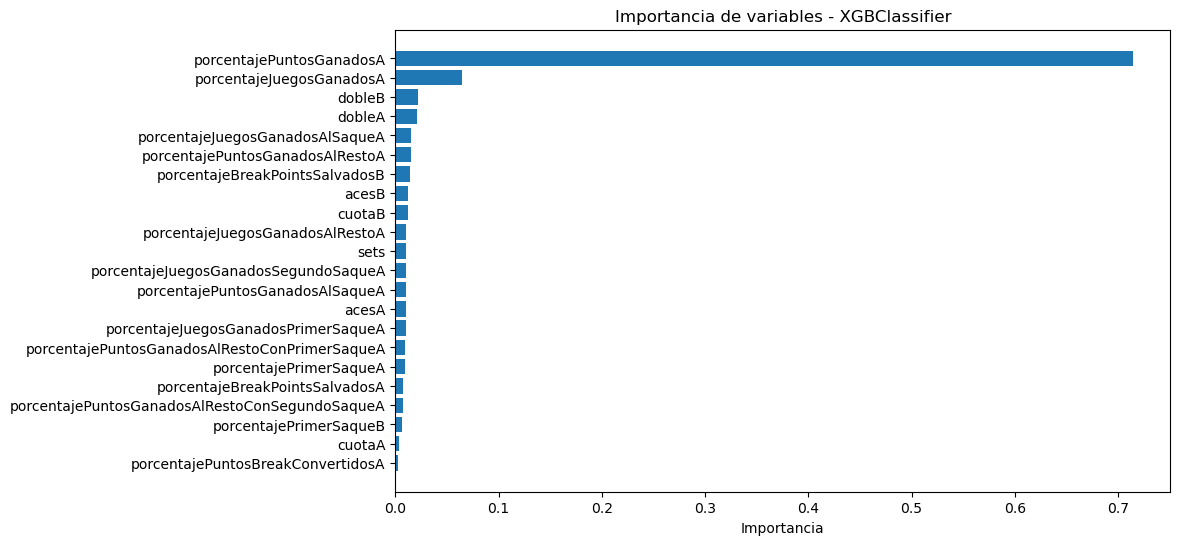

In [63]:
importancias = base.feature_importances_

# Crear un DataFrame para ordenarlas y visualizarlas mejor
df_importancias = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importancias
})

# Ordenar de mayor a menor importancia
df_importancias = df_importancias.sort_values(by='importance', ascending=False)

print(df_importancias)

# Graficar (opcional)
plt.figure(figsize=(10,6))
plt.barh(df_importancias['feature'], df_importancias['importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importancia')
plt.title('Importancia de variables - XGBClassifier')
plt.show()